This workbook begins using the environment we have setup on Azure Machine Learning to iterate through several multilayer perceptrons.

In [1]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.tensorboard import Tensorboard
from azureml.core.environment import Environment


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import log_runs, visualize_log, plot_accuracy

# Setup

Load in the resources created in the first notebook, and setup for these expirments

In [4]:
# Load the stored workspace
ws = Workspace.from_config()

In [5]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [6]:
## Try with our saved image
env = Environment.get(workspace=ws, name="waste-env-gpu")

In [7]:
# get our compoute cluster
# for cnn we will use a gpu cluster
compute_name = "gpu-cluster-NC6"
compute_target = ws.compute_targets[compute_name]

## Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration

In [8]:
%%writefile train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array) #, load_img)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.applications.vgg16 import VGG16

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)

# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')

parser.add_argument('--train_layers', 
                    type=int, 
                    dest='train_layers', 
                    default=0, 
                    help='number of layers of the transfer model to train')

    
parser.add_argument('--dense_nodes', 
                    type=str, 
                    dest='dense_nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--dense_activations', 
                    type=str, 
                    dest='dense_activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')

parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')
args = parser.parse_args()

# split list args into lists
dense_nodes = args.dense_nodes.split(',')
dense_activations = args.dense_activations.split(',')

# print to log for debuggig if necessary
print('Data folder:',args.data_path)
print('Layers to train:', args.train_layers)

print('Dense Nodes:', dense_nodes)
print('Dense Activations:', dense_activations)

# get azure run context
run = Run.get_context()
print('Environment:',run.get_environment().name)


# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(train_folder,
                                             target_size = (244, 244),
                                             batch_size = 32)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             target_size = (244, 244),
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             target_size = (244, 244),
                                             batch_size = num_test)

# model callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=3),
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]


# Set layers to train in VGG16 model


# Build the model
model = models.Sequential()

VGG = VGG16(weights='imagenet', include_top=False, input_shape=(244,244,3))
# Freeze layers
for layer in VGG.layers[:-args.train_layers]:
    layer.trainable = False

model.add(VGG)
model.add(layers.Flatten())

# create hidden layers based on parameters
for node, activation in zip(dense_nodes, dense_activations):
    print(f'Creating Dense layer with {node} nodes and activation={activation}')
    model.add(layers.Dense(node, activation=activation))

# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model and store history
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=args.epochs,
                    callbacks=my_callbacks)

print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

print('evaluating model on test set...')
model_val = model.evaluate(test_generator)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting train.py


In [9]:
if not os.path.exists('vgg16_train_script'):
    os.mkdir('vgg16_train_script')

# move the file to the upload dir
shutil.copy('train.py', 'vgg16_train_script/')
shutil.copy('utils.py', 'vgg16_train_script/')


'vgg16_train_script/utils.py'

## Iterate models

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel which will make this process comparatively fast.

In [10]:
# set the expiriment
experiment_name = 'vgg16'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [141]:
# create var to stor run objects
runs = []

### Model 1 - Baseline
- hidden layer 1: 64 nodes, sigmoid activation function
- optimizer: sgd

In [142]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [143]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'vgg16-dense64'})

runs[-1].tag('class', 'VGG16')
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('dense layers', '1')

### Start Tensorboard to monitor the runs

In [19]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [228]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

In [153]:
log = log_runs(runs, 'cnn')
log

{}

KeyError: 'test_loss'

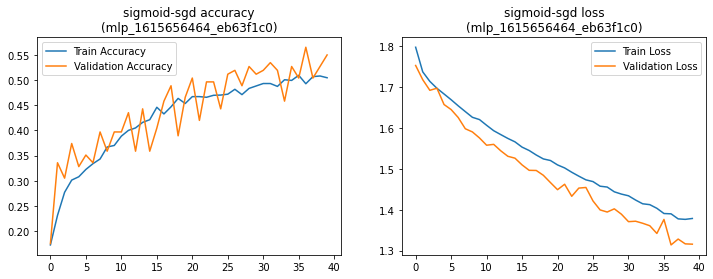

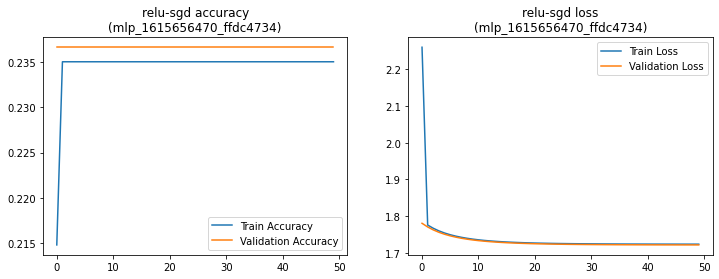

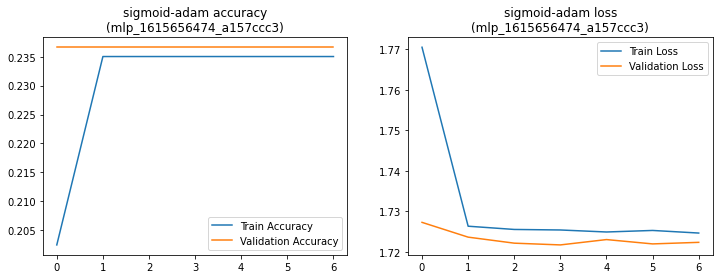

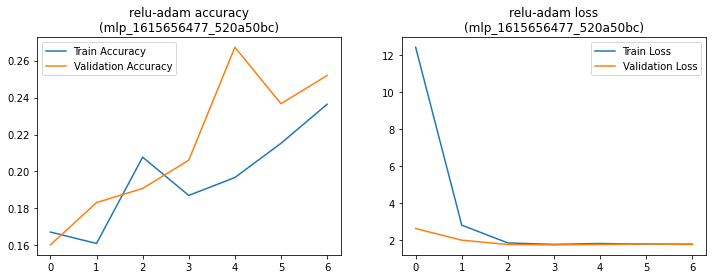

In [158]:
visualize_log(log)

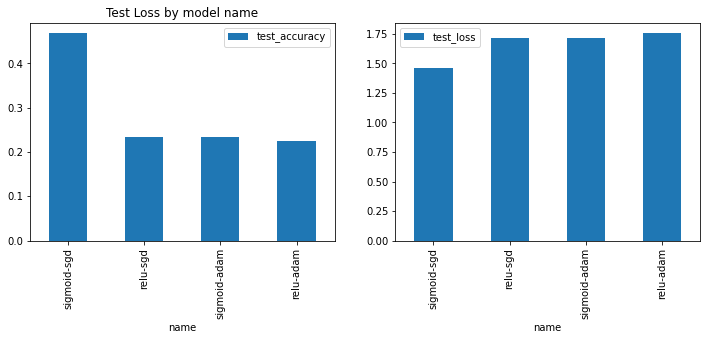

In [185]:
plot_accuracy(log)

Talk about runs here.

In [ ]:
runs2 = [runs[0]]

### Model 2
- hidden layer 1: 64 nodes, sigmoid activation function
- optimizer: sgd

In [154]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '64',
        '--dense_activations', 'sigmoid',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [155]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'vgg16-dense64-sigmoid'})

runs2[-1].tag('class', 'VGG16')
runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('dense layers', '1')

### Model 3 - Baseline
- hidden layer 1: 128 nodes, reliu activation function
- optimizer: sgd

In [156]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '128',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [157]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'vgg16-dense128-relu'})

runs2[-1].tag('class', 'VGG16')
runs2[-1].tag('activation', 'relu')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('dense layers', '1')

### Model 4 - Baseline
- hidden layer 1: 128 nodes, sigmoid activation function
- optimizer: sgd

In [158]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '128',
        '--dense_activations', 'sigmoid',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [159]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'vgg16-dense128-sigmoid'})

runs2[-1].tag('class', 'VGG16')
runs2[-1].tag('activation', 'relu')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('dense layers', '1')

In [19]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [228]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

In [162]:
runs2 = [runs[0]] + runs[-3:]

In [163]:
runs2

[Run(Experiment: vgg16,
 Id: vgg16_1615741912_055a875a,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: vgg16,
 Id: vgg16_1615742818_f6a2f010,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: vgg16,
 Id: vgg16_1615742827_afce90b7,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: vgg16,
 Id: vgg16_1615742832_ee32d716,
 Type: azureml.scriptrun,
 Status: Preparing)]

In [164]:
log = log_runs(runs2, 'vgg16')
log

{'test_loss': 0.8827635645866394, 'test_accuracy': 0.774193525314331}

{'test_loss': 0.5815511345863342, 'test_accuracy': 0.7822580933570862}

{'test_loss': 0.7411925792694092, 'test_accuracy': 0.8306451439857483}

{'test_loss': 0.5928134322166443, 'test_accuracy': 0.8225806355476379}

,name,type,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
vgg16_1615741912_055a875a,vgg16-dense64,vgg16,0.882764,0.774194,"[1.7886059284210205, 1.4079411029815674, 1.051...","[0.25088027119636536, 0.4335387349128723, 0.60...","[1.5614837408065796, 1.5532338619232178, 0.744...","[0.4351145029067993, 0.45038166642189026, 0.74..."
vgg16_1615742818_f6a2f010,vgg16-dense64-sigmoid,vgg16,0.581551,0.782258,"[1.4416505098342896, 0.9918886423110962, 0.775...","[0.4154929518699646, 0.6316021084785461, 0.739...","[1.1630631685256958, 0.7518298029899597, 0.648...","[0.5190839767456055, 0.7786259651184082, 0.740..."
vgg16_1615742827_afce90b7,vgg16-dense128-relu,vgg16,0.741193,0.830645,"[1.91116201877594, 1.6130764484405518, 1.28656...","[0.2517605721950531, 0.34419015049934387, 0.47...","[1.7086509466171265, 1.7167471647262573, 0.919...","[0.23664122819900513, 0.3435114622116089, 0.58..."
vgg16_1615742832_ee32d716,vgg16-dense128-sigmoid,vgg16,0.592813,0.822581,"[1.398279070854187, 0.9057489037513733, 0.6297...","[0.44014084339141846, 0.6632922291755676, 0.78...","[0.9122860431671143, 0.6965878009796143, 0.699...","[0.6564885377883911, 0.7557252049446106, 0.770..."


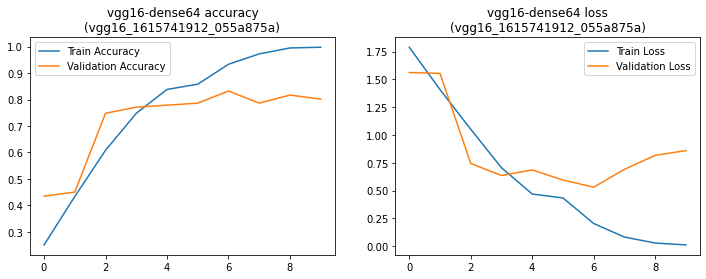

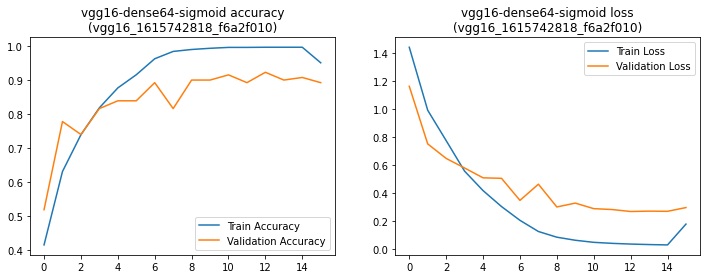

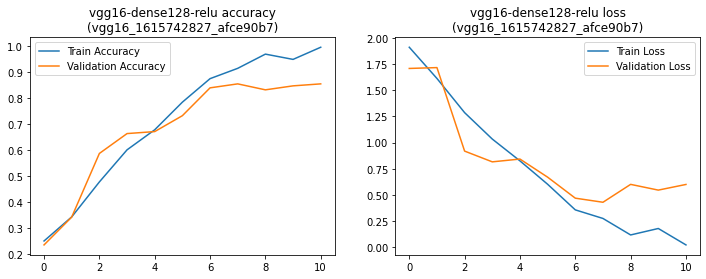

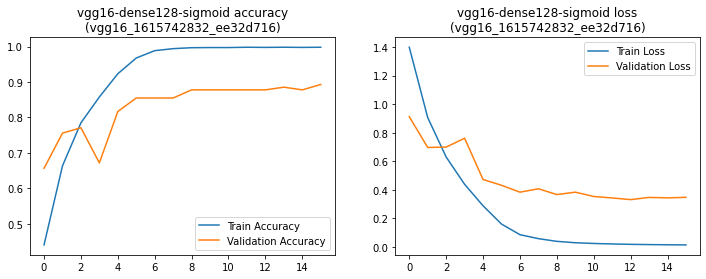

In [165]:
visualize_log(log)

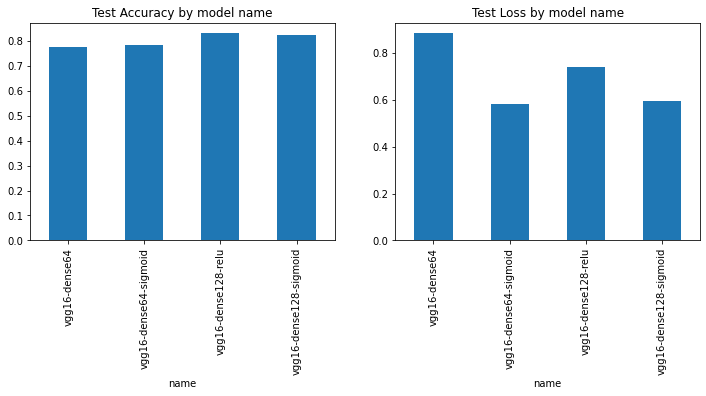

In [166]:
plot_accuracy(log)

Sigmoid gives similar results with a larger number of nodes but arrives at them in fewer epochs.  Lets try larger dense layers with sigmoid activation.

In [167]:
runs3 = [runs2[-1]]

### Model 5 - Baseline
- hidden layer 1: 256 nodes, sigmoid activation function
- optimizer: sgd

In [12]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '256',
        '--dense_activations', 'sigmoid',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [13]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'vgg16-dense256-sigmoid'})

runs3[-1].tag('class', 'VGG16')
runs3[-1].tag('activation', 'relu')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('dense layers', '1')

### Model 6 - Baseline
- hidden layer 1: 512 nodes, sigmoid activation function
- optimizer: sgd

In [14]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '512',
        '--dense_activations', 'sigmoid',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [15]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'vgg16-dense512-sigmoid'})

runs3[-1].tag('class', 'VGG16')
runs3[-1].tag('activation', 'relu')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('dense layers', '1')

### Model 7 - Baseline
- hidden layer 1: 1024 nodes, sigmoid activation function
- optimizer: sgd

In [16]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--train_layers', '0',
        '--dense_nodes', '1024',
        '--dense_activations', 'sigmoid',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='vgg16_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [17]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'vgg16-dense1024-sigmoid'})

runs3[-1].tag('class', 'VGG16')
runs3[-1].tag('activation', 'relu')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('dense layers', '1')